# Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from gensim import corpora
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer

import umap.umap_ as umap
import scipy.cluster.hierarchy as shc

from annoy import AnnoyIndex

# Data

In [26]:
df = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')

In [27]:
print(df.head())

       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...


In [28]:
df.shape

(962, 2)

# Data preprocessing
 CLEAN RESUME
 
remove any unnecessary information from resumes like URLs, hashtags, and special characters.⬇️⬇️

In [37]:
def cleanResume(resumeText):
    resumeText = re.sub('httpS+s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^x00-x7f]',r' ', resumeText) 
    resumeText = re.sub('s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))

In [38]:
df

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skill Programming Language P thon panda ...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Detail Ma 2013 to Ma 2017 B E ...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Area of Intere t Deep Learning Control S te...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skill R P thon SAP HANA Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Detail MCA YMCAUST Faridabad...
...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,Computer Skill Proficient in MS office ...
958,Testing,â Willingness to accept the challenges. â ...,Willingne to a ept the challenge Po...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",PERSONAL SKILLS Quick learner Eagerne...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power ...


# Vectorization
Preprocessing ‘cleaned_resume’ column

preprocess and convert the ‘cleaned_resume’ column into vectors.

using the ‘Tf-Idf’ method to get the vectors.
⬇️⬇️

In [6]:
requiredText = df['cleaned_resume'].values
requiredTarget = df['Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
X = word_vectorizer.transform(requiredText)

In [7]:
X

<962x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 124956 stored elements in Compressed Sparse Row format>

# Projection

Using UMAP projections we tuned the vectorizer parameters based on the iterative method ⬇️⬇️

In [8]:
def get_umap(data, c=None, n_neighbors=4, min_dist=0.2, n_components=2, metric='cosine', title=''):
    fit = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric,
    )
    u = fit.fit_transform(data)
    return u

data = X.toarray()
umap = get_umap(data)

new_df = pd.DataFrame()

new_df['umap_0'] = umap[:,0]
new_df['umap_1'] = umap[:,1]

In [9]:
new_df

,umap_0,umap_1
0,4.820650,8.324291
1,22.821167,3.217601
2,5.892550,11.088648
3,-11.447399,15.856790
4,13.494062,-6.686558
...,...,...
957,13.455695,1.842714
958,0.349865,-2.635715
959,0.171127,-9.817655
960,13.643373,-1.032262


<Figure size 720x504 with 0 Axes>

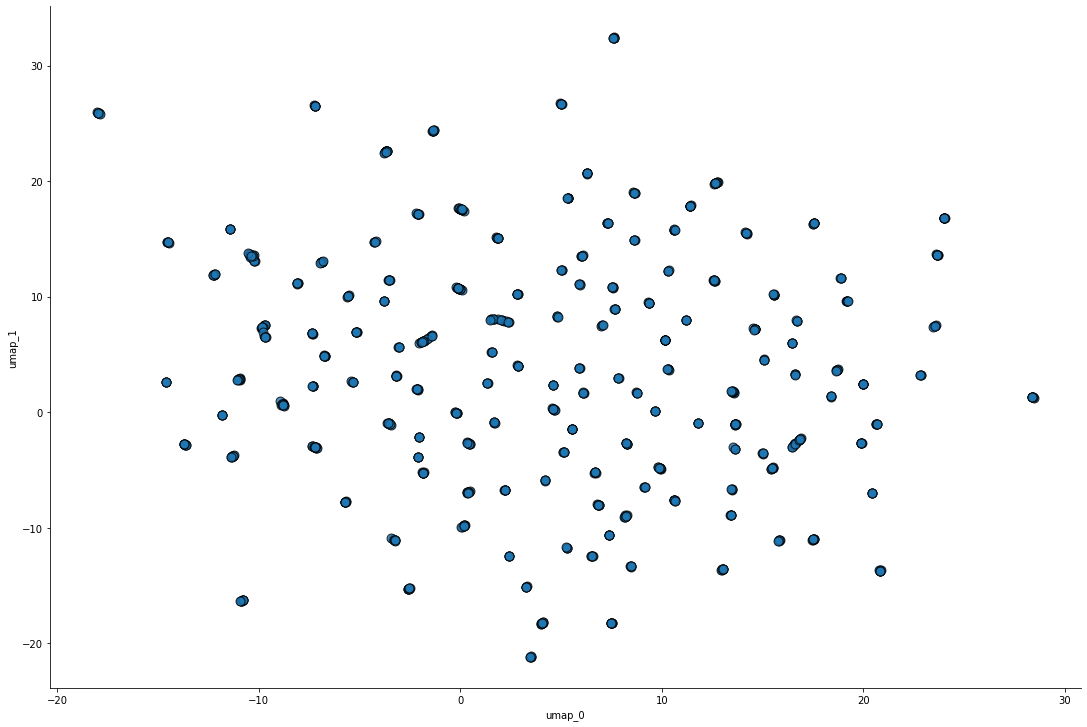

In [10]:
plt.figure(figsize=(10,7))
sns.lmplot(x="umap_0",
          y="umap_1",
          data=new_df,
          fit_reg=False,
          legend=True,
          height=10,
          aspect=1.5,
          palette="gist_ncar",
          scatter_kws={'edgecolor':'k',
                      's':80})

# Clustering

Using Cosine metrics

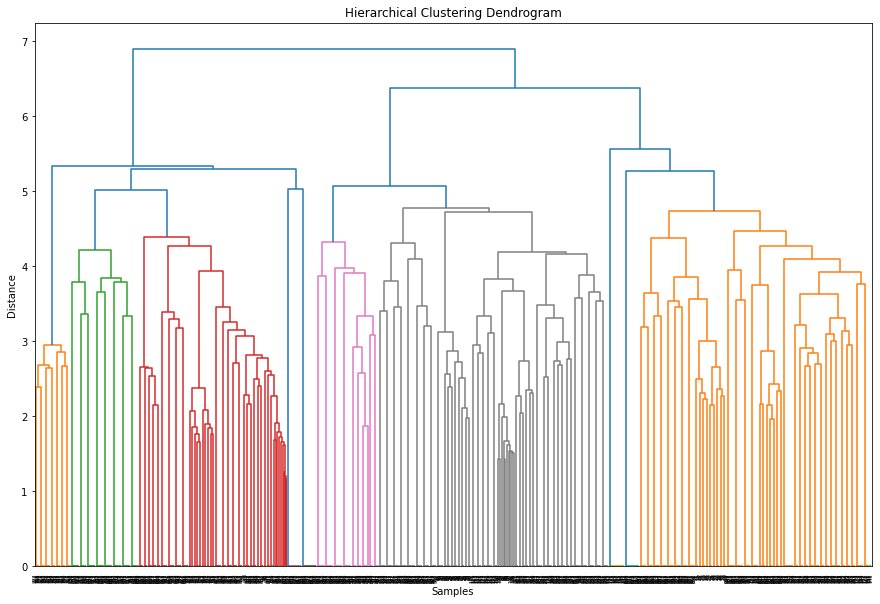

In [11]:
Z = shc.linkage(data, method='ward')

plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
dend = shc.dendrogram(Z)

<Figure size 720x504 with 0 Axes>

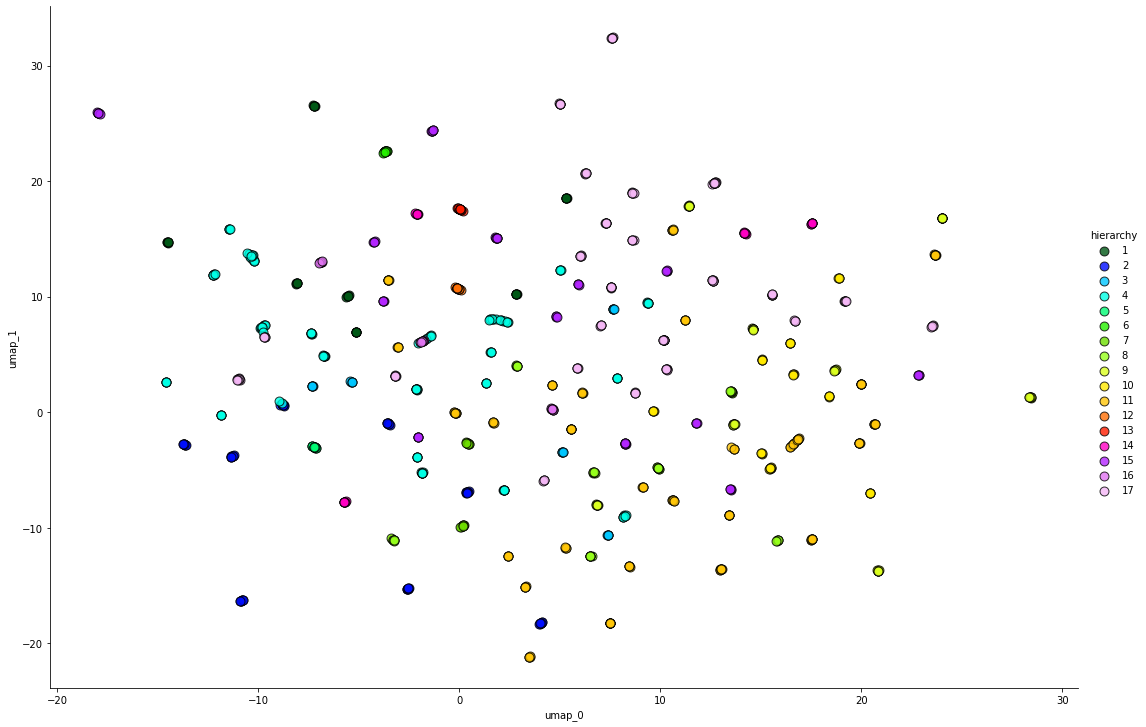

In [12]:
from scipy.cluster.hierarchy import fcluster

k=17
temp = fcluster(Z, k, criterion='maxclust')

new_df['hierarchy'] = temp

df_tf = pd.DataFrame(data, columns=word_vectorizer.get_feature_names())
df_tf['hierarchy'] = temp

plt.figure(figsize=(10,7))
sns.lmplot(x="umap_0",
          y="umap_1",
          data=new_df,
          fit_reg=False,
          hue='hierarchy',
          legend=True,
          height=10,
          aspect=1.5,
          palette="gist_ncar",
          scatter_kws={'edgecolor':'k',
                      's':80})

In [13]:
new_df

,umap_0,umap_1,hierarchy
0,4.820650,8.324291,15
1,22.821167,3.217601,15
2,5.892550,11.088648,15
3,-11.447399,15.856790,4
4,13.494062,-6.686558,15
...,...,...,...
957,13.455695,1.842714,8
958,0.349865,-2.635715,7
959,0.171127,-9.817655,7
960,13.643373,-1.032262,9


In [14]:
df_tf

,01,07,08,10,10g,11,11g,12,13,14,...,world,worldwide,writing,written,wrote,www,xml,xp,year,hierarchy
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.098684,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,8
958,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071703,0.000000,7
959,0.0,0.0,0.0,0.046989,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,7
960,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.139007,9


In [15]:
cl_names = ['Data Sci + BA', 'HR + Advocate', 'Sales', 'Art + fitness', 'Web des', 'Mech Eng', 'Civil Eng', 'SAP Dev', 'Automation Test + Test', 'Elect Eng', 'Operation Mgr', 'DevOps Engr', 'Network Security + Database', 'ETL Dev', 'DotNet Dev', 'Blockchain', 'Others']

p = len(cl_names)
cm = sns.light_palette("blue", as_cmap=True)

info_group = df_tf.groupby('hierarchy').mean().T.sort_values(2, ascending=False)
info_group.columns = cl_names
info_group = (info_group * 100).round(1).head(150) #was 50
info_group = info_group.style.background_gradient(cmap=cm)
info_group

,Data Sci + BA,HR + Advocate,Sales,Art + fitness,Web des,Mech Eng,Civil Eng,SAP Dev,Automation Test + Test,Elect Eng,Operation Mgr,DevOps Engr,Network Security + Database,ETL Dev,DotNet Dev,Blockchain,Others
operation,0.000000,6.900000,0.000000,1.400000,0.000000,6.200000,2.300000,4.100000,0.000000,2.900000,0.800000,0.000000,0.000000,2.200000,0.800000,0.000000,0.100000
en,1.500000,6.700000,1.900000,1.400000,0.000000,0.000000,2.700000,0.300000,0.000000,0.000000,1.900000,0.000000,5.700000,1.200000,1.400000,0.000000,0.800000
proce,4.300000,6.600000,2.700000,4.100000,5.400000,2.800000,7.600000,1.100000,0.000000,0.000000,0.100000,3.000000,0.000000,0.000000,2.300000,2.900000,0.900000
manager,1.200000,6.300000,1.400000,1.500000,0.000000,0.000000,2.900000,0.000000,0.000000,0.000000,4.400000,0.000000,0.000000,0.000000,0.200000,2.100000,0.300000
management,1.000000,6.100000,5.400000,4.000000,6.200000,0.000000,3.400000,4.200000,0.000000,2.200000,2.700000,2.600000,0.000000,4.000000,2.100000,2.500000,1.700000
tomer,2.500000,6.100000,3.100000,1.900000,2.700000,3.000000,5.600000,0.700000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,2.600000,0.000000,1.700000
deliver,0.000000,6.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000
cu,2.300000,5.900000,2.900000,3.000000,2.500000,5.700000,5.100000,0.800000,0.000000,0.000000,1.700000,0.000000,0.000000,1.800000,2.700000,0.000000,1.600000
timel,0.000000,5.600000,0.000000,0.300000,0.000000,0.000000,3.700000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ible,1.900000,5.600000,0.000000,1.700000,7.400000,0.000000,0.000000,1.900000,0.000000,0.000000,0.800000,0.000000,0.000000,1.600000,2.100000,0.000000,0.400000


values passed to leaf_label_func
leaves :  [1843, 1903, 1820, 1905, 1100, 1116, 1892, 1898, 1906, 1851, 1902, 1323, 1278, 1880, 1891, 1897, 1904]


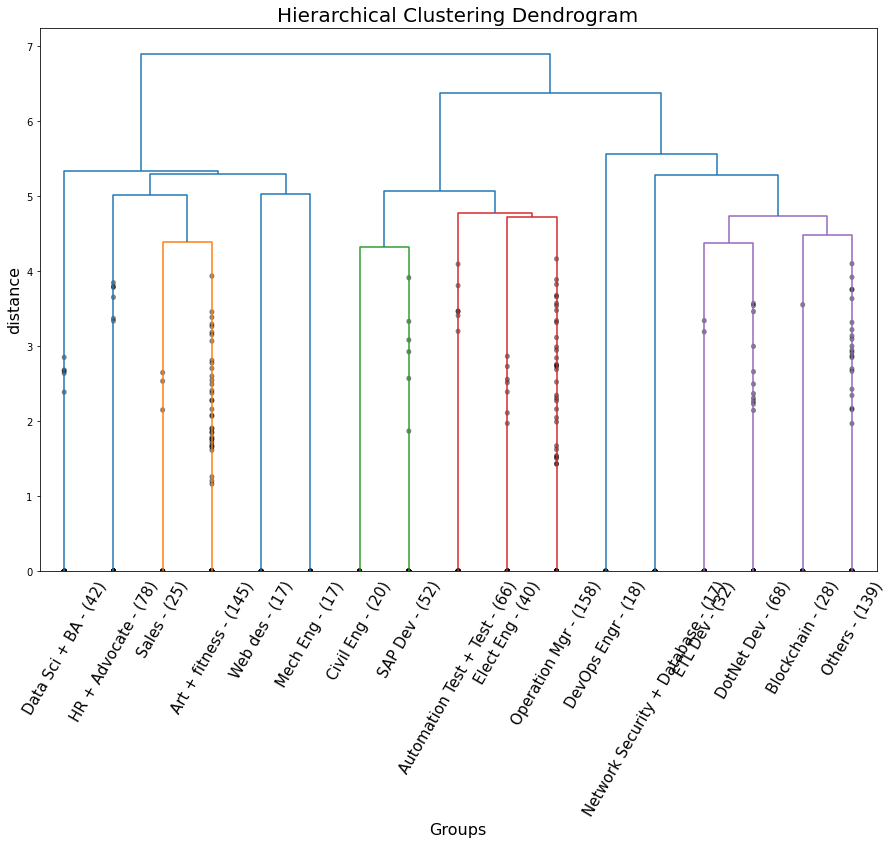

In [16]:
labels = cl_names
p=len(labels)

plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('Groups', fontsize=16)
plt.ylabel('distance', fontsize=16)

R = shc.dendrogram(
                    Z,
                    truncate_mode='lastp',
                    p=p,
                    no_plot=True,
                    )
print("values passed to leaf_label_func\nleaves : ", R["leaves"])

temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{} - {}".format(*temp[xx])

shc.dendrogram(
                Z,
                truncate_mode='lastp',
                p=p,
                leaf_label_func=llf,
                leaf_rotation=60,
                leaf_font_size=15,
                show_contracted=True,
                )

plt.show()

<Figure size 720x5616 with 0 Axes>

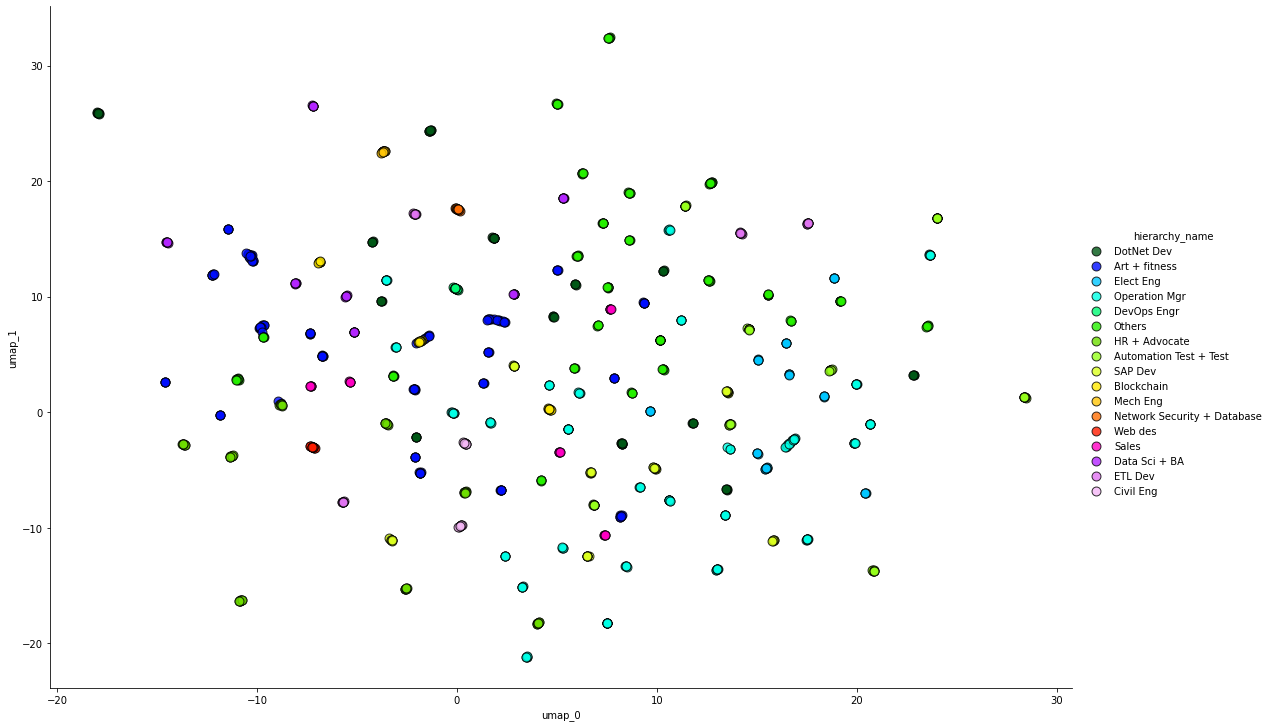

In [17]:
new_df['hierarchy_name'] = new_df['hierarchy'].apply(lambda x: cl_names[x-1])

plt.figure(figsize=(10,78))
sns.lmplot(x="umap_0",
           y="umap_1",
           data=new_df,
           fit_reg=False,
          hue='hierarchy_name',
          legend=True,
          height=10,
          aspect=1.5,
          palette="gist_ncar",
          scatter_kws={'edgecolor':'k',
                      's':80})

In [18]:
def perc_func(x, cv_id, h):
    if x.name != cv_id:
        return (x - h[cv_id]).fillna(0)
    else:
        return x
    
def get_matching(cv_id, n_similar, single_tree, relative=False):
    neighbors = single_tree.get_nns_by_vector(data[cv_id], n=n_similar)
    
    table = df_tf.loc[neighbors].drop(['hierarchy'],1).T.sort_values(cv_id, ascending=False)
    indexes = set()
    
    for cv in neighbors:
        indexes.update(set(table.sort_values(cv, ascending=False).index[:50].tolist()))
        
    h = table.loc[indexes].sort_values(cv_id, ascending=False)
    
    info = h.apply(lambda x: perc_func(x, cv_id, h)) if relative else h
    
    info = (info * 100).round(1).style.bar(align='mid', color=['#d65f5f', '#5fba7d'])
    
    return neighbors, info

def show_matching(cv_id, n_similar=1, metric='euclidean'):
    num_features = data.shape[1]
    single_tree = AnnoyIndex(num_features, metric=metric)
    
    i=0
    for vector in data:
        single_tree.add_item(i, vector)
        
        i += 1
    
    single_tree.build(1)
    
    neighbors, info = get_matching(cv_id, n_similar, single_tree, relative=False)
    return neighbors, info

In [19]:
res_id = 3
n_similar = 2

show_matching(res_id, n_similar=n_similar, metric='euclidean')[1]

,3,13
hana,22.300000,22.300000
sap,17.400000,17.400000
tr,14.400000,14.400000
tableau,13.700000,13.700000
modelling,13.700000,13.700000
enture,13.400000,13.400000
ultant,13.100000,13.100000
view,12.500000,12.500000
indu,12.000000,12.000000
model,11.900000,11.900000
